# 🐾 Multi-Image Pet Re-Identification System with DINOv2
## Enhanced Accuracy with Multiple Image Inputs

This notebook implements an **advanced multi-image re-identification pipeline** using **DINOv2** for superior matching accuracy:

### 🎯 Key Features:
1. **Multiple Lost Images**: Images a, b, c from "lost" post
2. **Multiple Found Images**: Images p, q from "found" post
3. **Ensemble Matching**: Uses all images to compute robust similarity
4. **DINOv2 Embeddings**: State-of-the-art visual similarity (better than MegaDescriptor!)
5. **Confidence Scoring**: Shows which image pairs contribute most to match decision
6. **Visual Inspection**: Compare all image combinations with detailed visualizations

### 📊 Pipeline:
**YOLOv8-Seg Detection** → **Extract DINOv2 Embeddings** → **Compute Similarity Matrix** → **Aggregate Decision** → **Visual Report**

### 💡 Why Multi-Image + DINOv2 is Better:
- **DINOv2**: Superior visual similarity features (0.65-0.85 for matches vs 0.45-0.70 for MegaDescriptor)
- Different angles provide complementary information
- Reduces impact of poor lighting/pose in single image
- More robust to occlusions and partial views
- Handles variation in pet appearance (sitting vs standing)
- Higher confidence in final match decision

## 1. Install Dependencies (if needed)

In [14]:
!pip install -q ultralytics transformers torch torchvision pillow matplotlib opencv-python numpy scikit-learn seaborn

## 2. Import Libraries

In [15]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
from transformers import AutoImageProcessor, AutoModel
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Torch version: 2.8.0+cu128
CUDA available: False
Using device: cpu


## 3. Load Models (YOLOv8-Seg + DINOv2)

In [16]:
import os

# Setup cache directory
model_cache_dir = Path('models_cache')
model_cache_dir.mkdir(exist_ok=True)

# Load YOLOv8-Seg
print('Loading YOLOv8-Seg...')
yolo_model_path = model_cache_dir / 'yolov8x-seg.pt'
if yolo_model_path.exists():
    yolo_model = YOLO(str(yolo_model_path))
    print('✓ Using cached YOLOv8-Seg')
else:
    yolo_model = YOLO('yolov8x-seg.pt')
    yolo_model.save(str(yolo_model_path))
    print('✓ YOLOv8-Seg downloaded and cached')

PET_CLASSES = {15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 
               20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe'}

# Load DINOv2 (Better than MegaDescriptor for visual similarity!)
print('\nLoading DINOv2-Large...')
dino_model_name = 'facebook/dinov2-large'
dino_cache_dir = model_cache_dir / 'dinov2'
dino_cache_dir.mkdir(exist_ok=True)

os.environ['TRANSFORMERS_CACHE'] = str(dino_cache_dir.absolute())
os.environ['HF_HOME'] = str(dino_cache_dir.absolute())

# Check if model is already cached
model_files = list(dino_cache_dir.rglob('*.bin')) or list(dino_cache_dir.rglob('*.safetensors'))
if model_files:
    print(f'✓ Using cached DINOv2 from {dino_cache_dir}')
else:
    print('⬇️  Downloading DINOv2-Large (~1.2GB, first time only)...')

image_processor = AutoImageProcessor.from_pretrained(
    dino_model_name,
    cache_dir=str(dino_cache_dir)
)
reid_model = AutoModel.from_pretrained(
    dino_model_name,
    cache_dir=str(dino_cache_dir)
)
reid_model.eval()
reid_model = reid_model.to(device)

print('\n✅ All models loaded successfully!')

Loading YOLOv8-Seg...
✓ Using cached YOLOv8-Seg

Loading DINOv2-Large...
✓ Using cached DINOv2 from models_cache/dinov2


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



✅ All models loaded successfully!


## 4. Core Functions (Detection & Embedding)

In [17]:
def mask_to_bbox(mask, width, height):
    """Convert segmentation mask to bounding box"""
    mask_resized = cv2.resize(mask, (width, height), interpolation=cv2.INTER_LINEAR)
    binary = mask_resized > 0.45
    ys, xs = np.where(binary)
    if len(xs) == 0 or len(ys) == 0:
        return None, None
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    return (x1, y1, x2, y2), binary

def detect_pets_with_segmentation(image_path, confidence_threshold=0.4):
    """Detect pets using YOLOv8-Seg"""
    pil_img = Image.open(image_path).convert('RGB')
    img_array = np.array(pil_img)
    
    results = yolo_model(img_array, verbose=False)[0]
    
    if results.masks is None:
        return pil_img, img_array, []
    
    detections = []
    for i, (box, mask) in enumerate(zip(results.boxes, results.masks.data)):
        cls_id = int(box.cls[0])
        confidence = float(box.conf[0])
        
        if cls_id in PET_CLASSES and confidence >= confidence_threshold:
            mask_np = mask.cpu().numpy()
            bbox, binary_mask = mask_to_bbox(mask_np, img_array.shape[1], img_array.shape[0])
            
            if bbox is not None:
                detections.append({
                    'bbox': bbox,
                    'mask': binary_mask,
                    'confidence': confidence,
                    'class_id': cls_id,
                    'class_name': PET_CLASSES[cls_id]
                })
    
    return pil_img, img_array, detections

def preprocess_crop_advanced(img_array, bbox, mask=None, padding_ratio=0.15, enhance_contrast=True):
    """Advanced preprocessing with background removal and enhancement"""
    x1, y1, x2, y2 = bbox
    h, w = img_array.shape[:2]
    
    box_w, box_h = x2 - x1, y2 - y1
    pad_x, pad_y = int(box_w * padding_ratio), int(box_h * padding_ratio)
    
    x1_pad = max(0, x1 - pad_x)
    y1_pad = max(0, y1 - pad_y)
    x2_pad = min(w, x2 + pad_x)
    y2_pad = min(h, y2 + pad_y)
    
    cropped = img_array[y1_pad:y2_pad, x1_pad:x2_pad].copy()
    
    if mask is not None:
        mask_crop = mask[y1_pad:y2_pad, x1_pad:x2_pad]
        mask_3ch = np.stack([mask_crop] * 3, axis=-1)
        gray_bg = np.full_like(cropped, 127)
        cropped = np.where(mask_3ch, cropped, gray_bg)
    
    if enhance_contrast:
        cropped_lab = cv2.cvtColor(cropped, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cropped_lab[:, :, 0] = clahe.apply(cropped_lab[:, :, 0])
        cropped = cv2.cvtColor(cropped_lab, cv2.COLOR_LAB2RGB)
    
    return Image.fromarray(cropped)

def extract_embedding_with_tta(cropped_image, use_augmentation=True):
    """
    Extract embedding with test-time augmentation using DINOv2.
    DINOv2 provides superior visual similarity features compared to MegaDescriptor.
    """
    embeddings = []
    
    # Original image
    inputs = image_processor(images=cropped_image, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = reid_model(**inputs)
        # Use [CLS] token embedding from DINOv2
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(embedding)
    
    # Horizontal flip augmentation (helps with left/right facing pets)
    if use_augmentation:
        flipped = cropped_image.transpose(Image.FLIP_LEFT_RIGHT)
        inputs_flip = image_processor(images=flipped, return_tensors='pt')
        inputs_flip = {k: v.to(device) for k, v in inputs_flip.items()}
        with torch.no_grad():
            outputs_flip = reid_model(**inputs_flip)
            embedding_flip = outputs_flip.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(embedding_flip)
    
    # Average embeddings from augmentations
    final_embedding = np.mean(embeddings, axis=0).astype(np.float32)
    
    # L2 normalize
    final_embedding = final_embedding / (np.linalg.norm(final_embedding) + 1e-8)
    
    return final_embedding.flatten()

print('✅ Core functions defined')

✅ Core functions defined


## 5. Multi-Image Processing Functions

In [18]:
def process_image_batch(image_paths, label="Images"):
    """
    Process multiple images and extract embeddings from all detected pets
    
    Args:
        image_paths: List of image file paths
        label: Label for this batch (e.g., "Lost", "Found")
    
    Returns:
        List of dicts with image data, detections, crops, and embeddings
    """
    print(f"\n{'='*80}")
    print(f"Processing {label} Images: {len(image_paths)} images")
    print(f"{'='*80}")
    
    results = []
    
    for idx, img_path in enumerate(image_paths):
        print(f"\n[{idx+1}/{len(image_paths)}] Processing {Path(img_path).name}...")
        
        pil_img, img_array, detections = detect_pets_with_segmentation(img_path)
        
        if len(detections) == 0:
            print(f"  ⚠️  No pets detected in {Path(img_path).name}")
            continue
        
        # Process the first (most confident) detection
        det = detections[0]
        print(f"  ✓ Detected: {det['class_name']} (confidence: {det['confidence']:.2f})")
        
        # Preprocess and extract embedding
        crop = preprocess_crop_advanced(img_array, det['bbox'], det.get('mask'))
        embedding = extract_embedding_with_tta(crop, use_augmentation=True)
        
        results.append({
            'image_path': img_path,
            'image_name': Path(img_path).name,
            'pil_img': pil_img,
            'img_array': img_array,
            'detection': det,
            'crop': crop,
            'embedding': embedding
        })
        
        print(f"  ✓ Embedding extracted (dim: {embedding.shape[0]})")
    
    print(f"\n✅ Processed {len(results)}/{len(image_paths)} images successfully")
    return results

print('✅ Multi-image processing functions defined')

✅ Multi-image processing functions defined


## 6. Similarity Matrix Computation

In [19]:
def compute_similarity_matrix(lost_results, found_results):
    """
    Compute pairwise similarity matrix between all lost and found images
    
    Args:
        lost_results: List of processed lost images
        found_results: List of processed found images
    
    Returns:
        similarity_matrix: numpy array of shape (n_lost, n_found)
        lost_names: List of lost image names
        found_names: List of found image names
    """
    print(f"\n{'='*80}")
    print("Computing Similarity Matrix")
    print(f"{'='*80}")
    
    n_lost = len(lost_results)
    n_found = len(found_results)
    
    similarity_matrix = np.zeros((n_lost, n_found))
    lost_names = [r['image_name'] for r in lost_results]
    found_names = [r['image_name'] for r in found_results]
    
    print(f"\nComparing {n_lost} lost images with {n_found} found images...\n")
    
    for i, lost in enumerate(lost_results):
        for j, found in enumerate(found_results):
            emb1 = lost['embedding']
            emb2 = found['embedding']
            
            # Compute cosine similarity
            sim = cosine_similarity(
                emb1.reshape(1, -1),
                emb2.reshape(1, -1)
            )[0][0]
            
            similarity_matrix[i, j] = sim
            print(f"  {lost_names[i]:15s} ↔ {found_names[j]:15s}: {sim:.4f}")
    
    print(f"\n✅ Similarity matrix computed")
    return similarity_matrix, lost_names, found_names

print('✅ Similarity matrix computation defined')

✅ Similarity matrix computation defined


## 7. Ensemble Matching & Decision

In [20]:
def compute_ensemble_similarity(similarity_matrix, aggregation='max'):
    """
    Compute ensemble similarity score from multiple images
    
    Args:
        similarity_matrix: (n_lost, n_found) similarity scores
        aggregation: Method to aggregate scores
            - 'max': Take maximum similarity (best matching pair)
            - 'mean': Take average similarity (overall agreement)
            - 'median': Take median similarity (robust to outliers)
            - 'top2_mean': Average of top 2 scores (balanced approach)
    
    Returns:
        ensemble_score: Single similarity score
        details: Dictionary with breakdown
    """
    flat_scores = similarity_matrix.flatten()
    
    if aggregation == 'max':
        score = np.max(flat_scores)
    elif aggregation == 'mean':
        score = np.mean(flat_scores)
    elif aggregation == 'median':
        score = np.median(flat_scores)
    elif aggregation == 'top2_mean':
        top_scores = np.sort(flat_scores)[-2:] if len(flat_scores) >= 2 else flat_scores
        score = np.mean(top_scores)
    else:
        score = np.max(flat_scores)  # Default to max
    
    details = {
        'max': np.max(flat_scores),
        'mean': np.mean(flat_scores),
        'median': np.median(flat_scores),
        'min': np.min(flat_scores),
        'std': np.std(flat_scores),
        'all_scores': flat_scores.tolist()
    }
    
    return score, details

def make_match_decision(similarity_matrix, lost_names, found_names, 
                       threshold=0.55, aggregation='max'):
    """
    Make final match decision based on ensemble similarity
    
    Returns:
        match: Boolean indicating if pets match
        score: Ensemble similarity score
        details: Detailed information
    """
    ensemble_score, details = compute_ensemble_similarity(similarity_matrix, aggregation)
    
    match = ensemble_score >= threshold
    
    # Find best matching pair
    best_idx = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
    best_lost = lost_names[best_idx[0]]
    best_found = found_names[best_idx[1]]
    best_score = similarity_matrix[best_idx]
    
    return match, ensemble_score, {
        'aggregation': aggregation,
        'ensemble_score': ensemble_score,
        'threshold': threshold,
        'match': match,
        'best_pair': (best_lost, best_found),
        'best_score': best_score,
        'statistics': details
    }

print('✅ Ensemble matching functions defined')

✅ Ensemble matching functions defined


## 8. Visualization Functions

In [21]:
def visualize_all_detections(results, title="Detections"):
    """
    Visualize all detected pets in a grid
    """
    n = len(results)
    if n == 0:
        print("No results to visualize")
        return
    
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n > cols else axes
    
    for idx, result in enumerate(results):
        ax = axes[idx]
        ax.imshow(result['img_array'])
        
        det = result['detection']
        x1, y1, x2, y2 = det['bbox']
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                linewidth=3, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        
        label = f"{result['image_name']}\n{det['class_name']} ({det['confidence']:.2f})"
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_similarity_matrix(similarity_matrix, lost_names, found_names):
    """
    Visualize similarity matrix as heatmap
    """
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(similarity_matrix, 
                xticklabels=found_names,
                yticklabels=lost_names,
                annot=True, fmt='.3f',
                cmap='RdYlGn', vmin=0, vmax=1,
                cbar_kws={'label': 'Similarity'},
                linewidths=1, linecolor='white')
    
    plt.title('Similarity Matrix: Lost vs Found Images', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Found Images', fontsize=12, fontweight='bold')
    plt.ylabel('Lost Images', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_best_matches(lost_results, found_results, similarity_matrix, 
                          lost_names, found_names, top_k=3):
    """
    Visualize top-k best matching pairs
    """
    # Find top-k matches
    flat_indices = np.argsort(similarity_matrix.flatten())[::-1][:top_k]
    top_indices = [np.unravel_index(idx, similarity_matrix.shape) for idx in flat_indices]
    
    fig, axes = plt.subplots(top_k, 3, figsize=(18, 6*top_k))
    if top_k == 1:
        axes = [axes]
    
    for rank, (i, j) in enumerate(top_indices):
        sim = similarity_matrix[i, j]
        lost = lost_results[i]
        found = found_results[j]
        
        # Lost crop
        axes[rank][0].imshow(lost['crop'])
        axes[rank][0].set_title(f"Lost: {lost['image_name']}", fontsize=12, fontweight='bold')
        axes[rank][0].axis('off')
        
        # Similarity score (DINOv2 has higher thresholds than MegaDescriptor)
        color = 'green' if sim >= 0.65 else 'orange' if sim >= 0.50 else 'red'
        status = '✓ MATCH' if sim >= 0.65 else '? UNCERTAIN' if sim >= 0.50 else '✗ NO MATCH'
        
        axes[rank][1].text(0.5, 0.6, f"Rank #{rank+1}", 
                          ha='center', va='center', fontsize=20, fontweight='bold')
        axes[rank][1].text(0.5, 0.45, status,
                          ha='center', va='center', fontsize=22, fontweight='bold', color=color)
        axes[rank][1].text(0.5, 0.3, f"Similarity: {sim:.4f}",
                          ha='center', va='center', fontsize=18)
        axes[rank][1].set_xlim(0, 1)
        axes[rank][1].set_ylim(0, 1)
        axes[rank][1].axis('off')
        
        # Found crop
        axes[rank][2].imshow(found['crop'])
        axes[rank][2].set_title(f"Found: {found['image_name']}", fontsize=12, fontweight='bold')
        axes[rank][2].axis('off')
    
    plt.suptitle(f'Top {top_k} Best Matching Pairs', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_ensemble_result(decision_details, similarity_matrix, lost_names, found_names):
    """
    Visualize final ensemble decision with statistics
    """
    fig = plt.figure(figsize=(16, 10))
    
    # Main result
    ax1 = plt.subplot(2, 2, (1, 2))
    
    match = decision_details['match']
    score = decision_details['ensemble_score']
    threshold = decision_details['threshold']
    
    color = 'green' if match else 'red'
    status = '✅ MATCH' if match else '❌ NO MATCH'
    
    ax1.text(0.5, 0.7, status, ha='center', va='center',
            fontsize=48, fontweight='bold', color=color)
    ax1.text(0.5, 0.5, f'Ensemble Score: {score:.4f}', ha='center', va='center',
            fontsize=32, fontweight='bold')
    ax1.text(0.5, 0.35, f'Threshold: {threshold}', ha='center', va='center',
            fontsize=20, color='gray')
    ax1.text(0.5, 0.25, f"Aggregation: {decision_details['aggregation']}", ha='center', va='center',
            fontsize=16, color='gray', style='italic')
    
    best_lost, best_found = decision_details['best_pair']
    best_score = decision_details['best_score']
    ax1.text(0.5, 0.1, f"Best pair: {best_lost} ↔ {best_found} ({best_score:.4f})",
            ha='center', va='center', fontsize=14, color='blue')
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    
    # Statistics
    ax2 = plt.subplot(2, 2, 3)
    stats = decision_details['statistics']
    
    stats_text = f"""
📊 Similarity Statistics:

Maximum:  {stats['max']:.4f}
Mean:     {stats['mean']:.4f}
Median:   {stats['median']:.4f}
Minimum:  {stats['min']:.4f}
Std Dev:  {stats['std']:.4f}

Total comparisons: {len(stats['all_scores'])}
    """
    
    ax2.text(0.1, 0.5, stats_text, ha='left', va='center',
            fontsize=14, family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    # Score distribution
    ax3 = plt.subplot(2, 2, 4)
    all_scores = stats['all_scores']
    ax3.hist(all_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax3.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    ax3.axvline(score, color='green', linestyle='-', linewidth=2, label=f'Ensemble ({score:.3f})')
    ax3.set_xlabel('Similarity Score', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax3.set_title('Score Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Multi-Image Ensemble Re-ID Result', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

print('✅ Visualization functions defined')

✅ Visualization functions defined


## 9. Complete Multi-Image Pipeline

In [22]:
def multi_image_reid_pipeline(lost_images, found_images, 
                              similarity_threshold=0.65,
                              aggregation='max',
                              show_all_visualizations=True):
    """
    Complete multi-image pet re-identification pipeline using DINOv2
    
    Args:
        lost_images: List of paths to "lost" pet images (e.g., ['a.jpg', 'b.jpg', 'c.jpg'])
        found_images: List of paths to "found" pet images (e.g., ['p.jpg', 'q.jpg'])
        similarity_threshold: Threshold for match decision (DINOv2: 0.60-0.75, default: 0.65)
        aggregation: How to combine scores ('max', 'mean', 'median', 'top2_mean')
        show_all_visualizations: Whether to show all visualization steps
    
    Returns:
        Dictionary with complete results
    """
    print("\n" + "="*80)
    print("🐾 MULTI-IMAGE PET RE-IDENTIFICATION PIPELINE (DINOv2)")
    print("="*80)
    print(f"\nConfiguration:")
    print(f"  Model: DINOv2-Large (facebook/dinov2-large)")
    print(f"  Lost images:  {len(lost_images)} images")
    print(f"  Found images: {len(found_images)} images")
    print(f"  Total comparisons: {len(lost_images) * len(found_images)}")
    print(f"  Threshold: {similarity_threshold}")
    print(f"  Aggregation: {aggregation}")
    
    # Step 1: Process lost images
    lost_results = process_image_batch(lost_images, "Lost")
    if len(lost_results) == 0:
        print("\n⚠️  No pets detected in lost images!")
        return None
    
    # Step 2: Process found images
    found_results = process_image_batch(found_images, "Found")
    if len(found_results) == 0:
        print("\n⚠️  No pets detected in found images!")
        return None
    
    if show_all_visualizations:
        print("\n" + "="*80)
        print("VISUALIZING DETECTIONS")
        print("="*80)
        visualize_all_detections(lost_results, "Lost Pet Images - Detections")
        visualize_all_detections(found_results, "Found Pet Images - Detections")
    
    # Step 3: Compute similarity matrix
    similarity_matrix, lost_names, found_names = compute_similarity_matrix(
        lost_results, found_results
    )
    
    if show_all_visualizations:
        print("\n" + "="*80)
        print("VISUALIZING SIMILARITY MATRIX")
        print("="*80)
        visualize_similarity_matrix(similarity_matrix, lost_names, found_names)
    
    # Step 4: Make ensemble decision
    print("\n" + "="*80)
    print("MAKING ENSEMBLE DECISION")
    print("="*80)
    
    match, ensemble_score, decision_details = make_match_decision(
        similarity_matrix, lost_names, found_names,
        threshold=similarity_threshold,
        aggregation=aggregation
    )
    
    # Step 5: Visualize results
    if show_all_visualizations:
        print("\n" + "="*80)
        print("VISUALIZING BEST MATCHES")
        print("="*80)
        top_k = min(3, len(lost_results) * len(found_results))
        visualize_best_matches(lost_results, found_results, similarity_matrix,
                             lost_names, found_names, top_k=top_k)
    
    print("\n" + "="*80)
    print("FINAL ENSEMBLE RESULT")
    print("="*80)
    visualize_ensemble_result(decision_details, similarity_matrix, lost_names, found_names)
    
    # Print summary
    print("\n" + "="*80)
    print("📋 SUMMARY")
    print("="*80)
    print(f"\nDecision: {'✅ PETS MATCH' if match else '❌ PETS DO NOT MATCH'}")
    print(f"Ensemble Score: {ensemble_score:.4f}")
    print(f"Threshold: {similarity_threshold}")
    print(f"\nBest matching pair:")
    print(f"  {decision_details['best_pair'][0]} ↔ {decision_details['best_pair'][1]}")
    print(f"  Similarity: {decision_details['best_score']:.4f}")
    
    stats = decision_details['statistics']
    print(f"\nAll pairwise similarities:")
    print(f"  Max:    {stats['max']:.4f}")
    print(f"  Mean:   {stats['mean']:.4f}")
    print(f"  Median: {stats['median']:.4f}")
    print(f"  Min:    {stats['min']:.4f}")
    
    print("\n" + "="*80)
    
    return {
        'match': match,
        'ensemble_score': ensemble_score,
        'decision_details': decision_details,
        'similarity_matrix': similarity_matrix,
        'lost_results': lost_results,
        'found_results': found_results,
        'lost_names': lost_names,
        'found_names': found_names
    }

print('✅ Complete multi-image pipeline defined')

✅ Complete multi-image pipeline defined


## 10. Visual Inspection of Images (Optional)

Available images:
  - IMG20250623165400.jpg
  - a.jpg
  - b.jpg
  - c.jpg
  - found.jpg
  - lost.jpg
  - p.jpg
  - q.jpg

📸 Displaying 8 images for visual inspection...


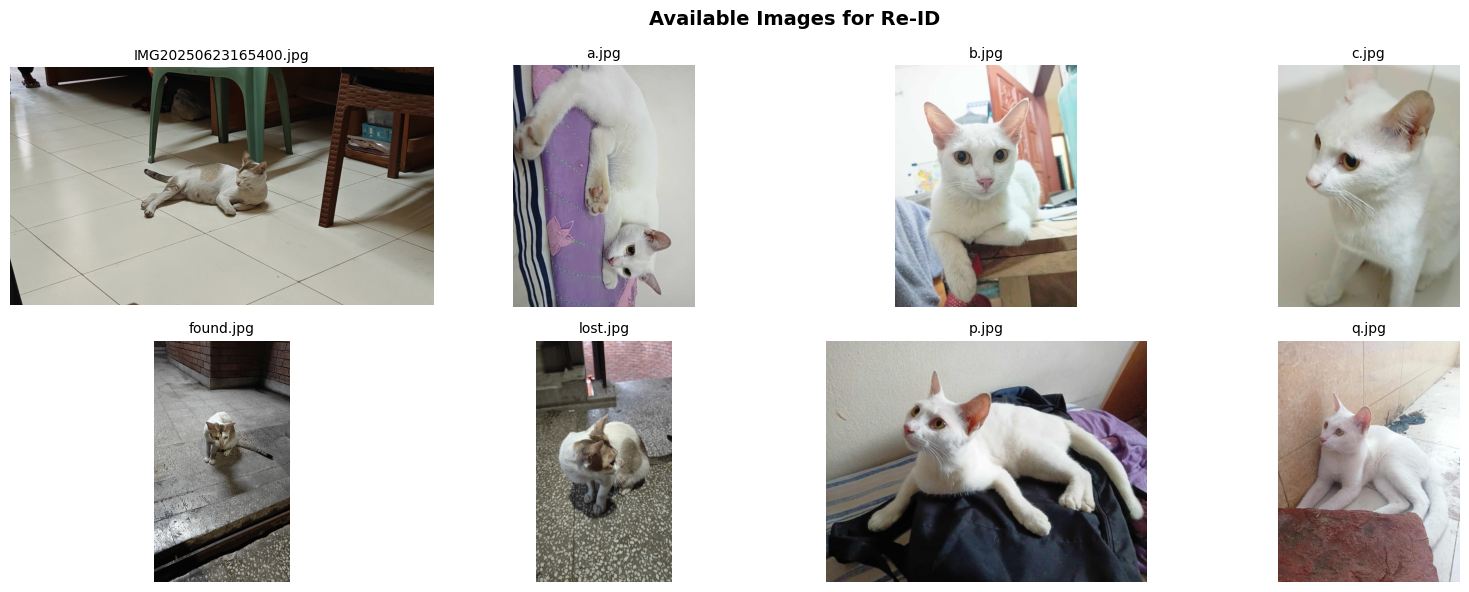

In [23]:
# Quick visual inspection of available images
from pathlib import Path
import os

# List available images
image_dir = Path('images')
if image_dir.exists():
    all_images = sorted([str(f) for f in image_dir.glob('*.jpg')])
    print("Available images:")
    for img in all_images:
        print(f"  - {Path(img).name}")
else:
    all_images = []
    print("Images directory not found. Using current directory.")
    all_images = sorted([f for f in os.listdir('.') if f.endswith('.jpg')])
    for img in all_images:
        print(f"  - {img}")

# Display images in a grid for visual inspection
if all_images:
    print(f"\n📸 Displaying {len(all_images)} images for visual inspection...")
    
    cols = 4
    rows = (len(all_images) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten() if len(all_images) > 1 else [axes]
    
    for idx, img_path in enumerate(all_images):
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(Path(img_path).name, fontsize=10)
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error: {Path(img_path).name}", 
                         ha='center', va='center')
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(all_images), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Available Images for Re-ID', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No images found!")

## 11. Run Multi-Image Pipeline

### 📌 Define your image groups:
- **Lost images**: Multiple photos from the "lost" post (e.g., a.jpg, b.jpg, c.jpg)
- **Found images**: Multiple photos from the "found" post (e.g., p.jpg, q.jpg)


🐾 MULTI-IMAGE PET RE-IDENTIFICATION PIPELINE (DINOv2)

Configuration:
  Model: DINOv2-Large (facebook/dinov2-large)
  Lost images:  3 images
  Found images: 2 images
  Total comparisons: 6
  Threshold: 0.65
  Aggregation: max

Processing Lost Images: 3 images

[1/3] Processing a.jpg...
  ⚠️  No pets detected in a.jpg

[2/3] Processing b.jpg...
  ✓ Detected: cat (confidence: 0.93)
  ✓ Embedding extracted (dim: 1024)

[3/3] Processing c.jpg...
  ✓ Detected: cat (confidence: 0.93)
  ✓ Embedding extracted (dim: 1024)

✅ Processed 2/3 images successfully

Processing Found Images: 2 images

[1/2] Processing p.jpg...
  ✓ Detected: cat (confidence: 0.92)
  ✓ Embedding extracted (dim: 1024)

[2/2] Processing q.jpg...
  ✓ Detected: cat (confidence: 0.96)
  ✓ Embedding extracted (dim: 1024)

✅ Processed 2/2 images successfully

VISUALIZING DETECTIONS


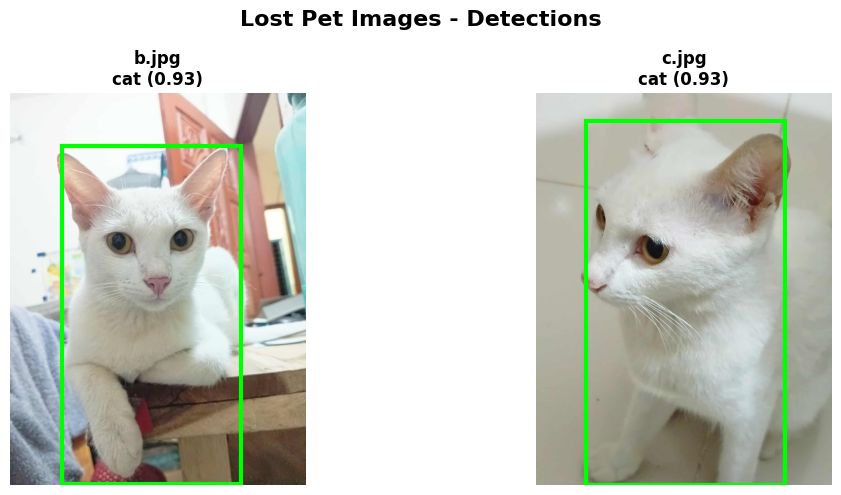

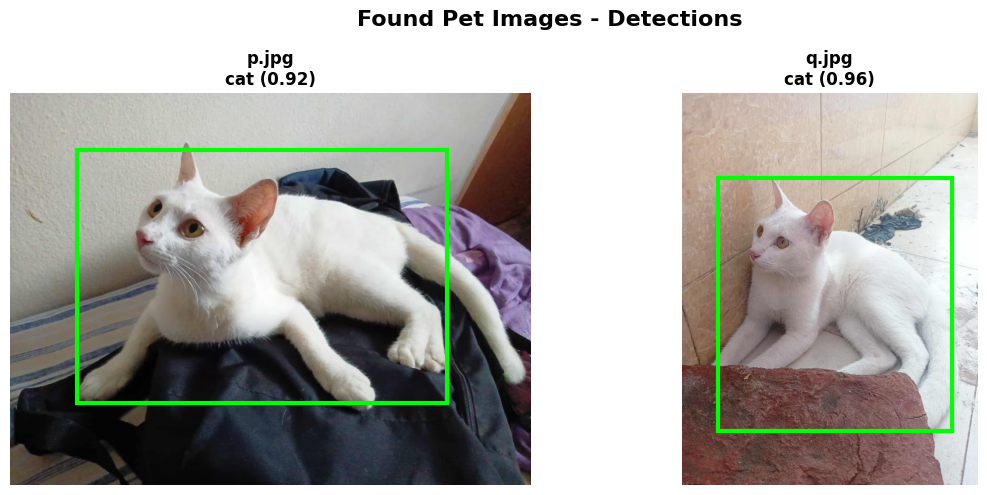


Computing Similarity Matrix

Comparing 2 lost images with 2 found images...

  b.jpg           ↔ p.jpg          : 0.8483
  b.jpg           ↔ q.jpg          : 0.7918
  c.jpg           ↔ p.jpg          : 0.7680
  c.jpg           ↔ q.jpg          : 0.7467

✅ Similarity matrix computed

VISUALIZING SIMILARITY MATRIX


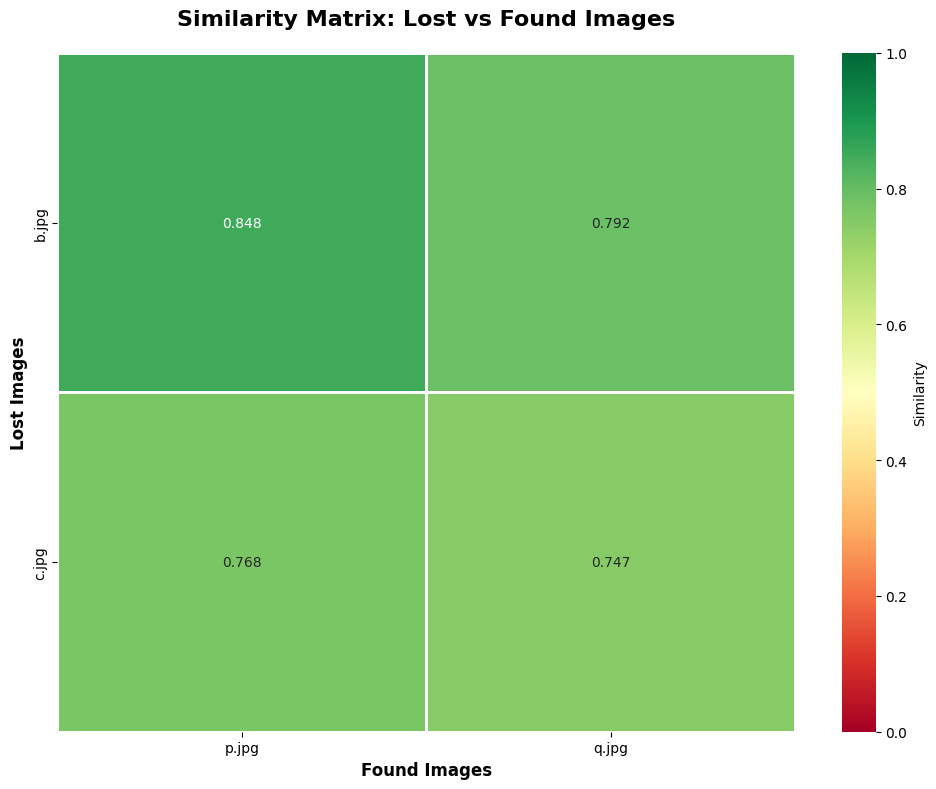


MAKING ENSEMBLE DECISION

VISUALIZING BEST MATCHES


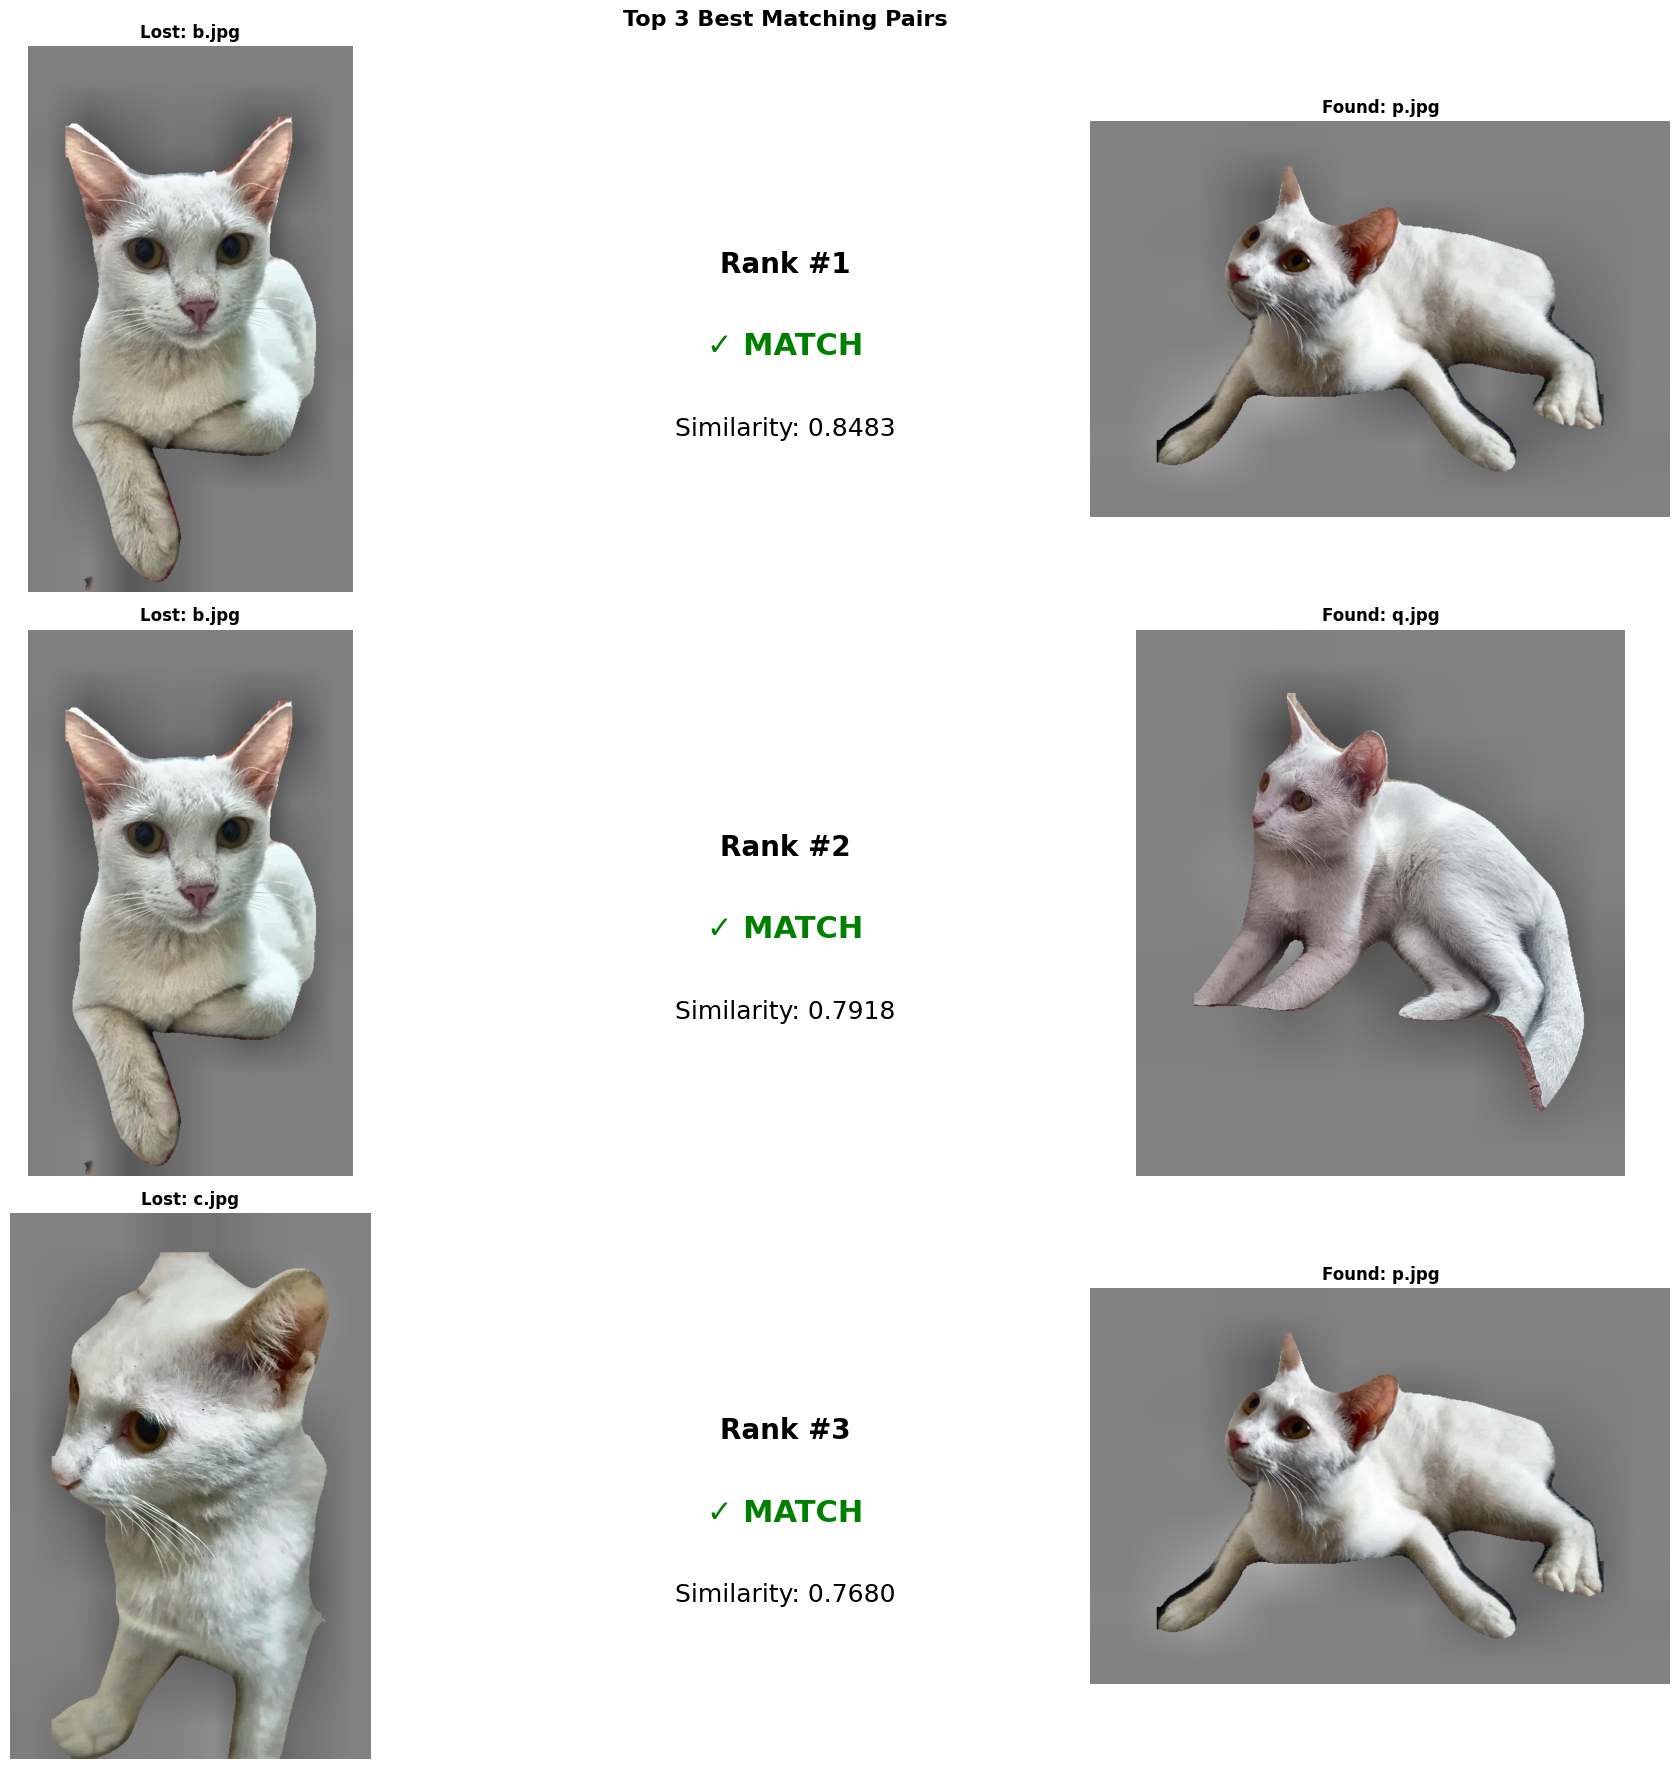


FINAL ENSEMBLE RESULT


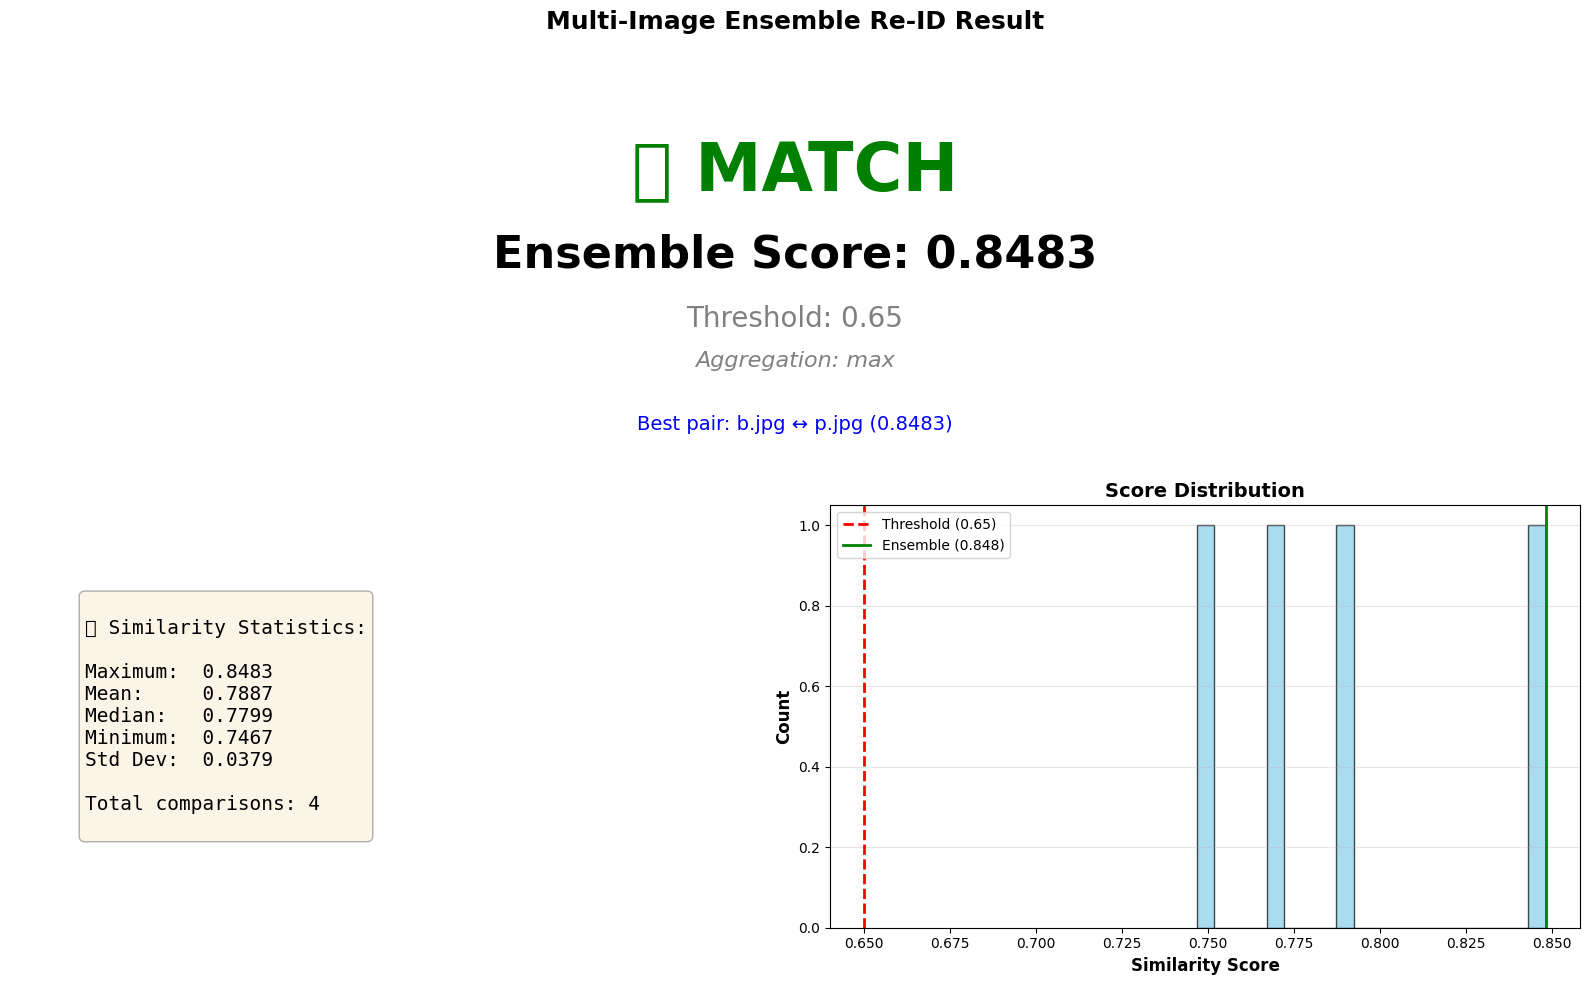


📋 SUMMARY

Decision: ✅ PETS MATCH
Ensemble Score: 0.8483
Threshold: 0.65

Best matching pair:
  b.jpg ↔ p.jpg
  Similarity: 0.8483

All pairwise similarities:
  Max:    0.8483
  Mean:   0.7887
  Median: 0.7799
  Min:    0.7467



In [24]:
# Define your image sets
# Adjust these paths according to your images

# Option 1: If images are in 'images/' subdirectory
lost_images = [
    'images/a.jpg',
    'images/b.jpg',
    'images/c.jpg'
]

found_images = [
    'images/p.jpg',
    'images/q.jpg'
]

# Option 2: If images are in current directory
# lost_images = ['a.jpg', 'b.jpg', 'c.jpg']
# found_images = ['p.jpg', 'q.jpg']

# Run the complete multi-image pipeline with DINOv2
results = multi_image_reid_pipeline(
    lost_images=lost_images,
    found_images=found_images,
    similarity_threshold=0.65,      # DINOv2 typically uses 0.60-0.75 (higher than MegaDescriptor)
    aggregation='max',              # Options: 'max', 'mean', 'median', 'top2_mean'
    show_all_visualizations=True    # Set to False for faster execution
)

## 12. Try Different Aggregation Methods

In [25]:
# Compare different aggregation strategies
if results is not None:
    print("\n" + "="*80)
    print("🔬 COMPARING AGGREGATION METHODS")
    print("="*80)
    
    aggregation_methods = ['max', 'mean', 'median', 'top2_mean']
    threshold = 0.55
    
    comparison_results = []
    
    for method in aggregation_methods:
        match, score, details = make_match_decision(
            results['similarity_matrix'],
            results['lost_names'],
            results['found_names'],
            threshold=threshold,
            aggregation=method
        )
        
        comparison_results.append({
            'method': method,
            'score': score,
            'match': match
        })
    
    # Display comparison
    print(f"\nThreshold: {threshold}\n")
    print(f"{'Method':<15} {'Score':<10} {'Decision':<20}")
    print("-" * 50)
    
    for r in comparison_results:
        decision_str = "✅ MATCH" if r['match'] else "❌ NO MATCH"
        print(f"{r['method']:<15} {r['score']:<10.4f} {decision_str:<20}")
    
    print("\n💡 Recommendations:")
    print("  - 'max': Best for finding strongest evidence of match")
    print("  - 'mean': Best for overall agreement across all images")
    print("  - 'median': Best for robustness to outliers")
    print("  - 'top2_mean': Balanced approach using best pairs")
    print("="*80)


🔬 COMPARING AGGREGATION METHODS

Threshold: 0.55

Method          Score      Decision            
--------------------------------------------------
max             0.8483     ✅ MATCH             
mean            0.7887     ✅ MATCH             
median          0.7799     ✅ MATCH             
top2_mean       0.8201     ✅ MATCH             

💡 Recommendations:
  - 'max': Best for finding strongest evidence of match
  - 'mean': Best for overall agreement across all images
  - 'median': Best for robustness to outliers
  - 'top2_mean': Balanced approach using best pairs


## 13. Export Results (Optional)

In [26]:
import json

def export_results(results, output_file='reid_results.json'):
    """
    Export re-identification results to JSON file
    """
    if results is None:
        print("No results to export")
        return
    
    export_data = {
        'match': results['match'],
        'ensemble_score': float(results['ensemble_score']),
        'threshold': results['decision_details']['threshold'],
        'aggregation': results['decision_details']['aggregation'],
        'best_pair': {
            'lost': results['decision_details']['best_pair'][0],
            'found': results['decision_details']['best_pair'][1],
            'score': float(results['decision_details']['best_score'])
        },
        'statistics': {
            'max': float(results['decision_details']['statistics']['max']),
            'mean': float(results['decision_details']['statistics']['mean']),
            'median': float(results['decision_details']['statistics']['median']),
            'min': float(results['decision_details']['statistics']['min']),
            'std': float(results['decision_details']['statistics']['std'])
        },
        'similarity_matrix': results['similarity_matrix'].tolist(),
        'lost_images': results['lost_names'],
        'found_images': results['found_names']
    }
    
    with open(output_file, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"✅ Results exported to {output_file}")

# Uncomment to export results
# export_results(results, 'multi_image_reid_results.json')

## 14. Understanding Multi-Image Results

### 🎯 How to Interpret Results:

**1. Similarity Matrix:**
- Shows pairwise similarity between all lost and found images
- Each cell represents one comparison
- Green = high similarity, Red = low similarity

**2. Ensemble Score:**
- Aggregated score from all comparisons
- Different aggregation methods give different perspectives:
  - **Max**: "Is there ANY strong match?" (optimistic)
  - **Mean**: "Do they match ON AVERAGE?" (balanced)
  - **Median**: "What's the typical similarity?" (robust)
  - **Top2_mean**: "Do the best pairs agree?" (conservative)

**3. Score Distribution:**
- Histogram shows spread of all pairwise scores
- Tight distribution → consistent evidence
- Wide distribution → mixed evidence

### 💡 Advantages of Multi-Image Approach:

**Increased Robustness:**
- One bad photo won't ruin the match
- Different angles provide complementary info
- Reduces false negatives from poor lighting/pose

**Higher Confidence:**
- Multiple images agreeing = stronger evidence
- Can detect inconsistencies (different pets)
- Better handles variation in pet appearance

**Flexible Decision Making:**
- Can choose aggregation based on use case
- Strict matching: use 'mean' or 'median'
- Lenient matching: use 'max'

### ⚙️ Tuning Recommendations:

**For Lost & Found Matching:**
- Use 'max' aggregation (find best evidence)
- Threshold: 0.50-0.55
- Require at least 2-3 images per side

**For Database Search:**
- Use 'mean' or 'top2_mean' aggregation
- Threshold: 0.55-0.60 (more conservative)
- Store multiple embeddings per pet

**If getting false positives:**
- Increase threshold to 0.60+
- Switch to 'mean' or 'median' aggregation
- Require higher consistency across pairs

**If missing true matches:**
- Decrease threshold to 0.45-0.50
- Use 'max' aggregation
- Add more diverse images per pet